# ECOanalysis showcase

It is presented how already processed data can be analysed, taking advantage of the ECO framework.<br />
This showcase is not limited to data processed the script provided in ECOprocessing or NEMO data, but is written in all its variable names.

This analysis is divided into 3 steps:

    - Step 1: Import the data and prepare the ECOdiagnostic classes
    - Step 2: Perform additional analysis on the processed data
    - Step 3: Visualize the data

### Step 1: Data import

The data used here is provided in ECOanalysis/data/EXP_test/. 

It is provided as renamed raw data, which means that the full processing has not been performed yet.<br/>
If no data with "\*_proc\*.nc" in its name is available: **Run ECOprocessing first** (Tutorial in ECOprocessing/Readme.txt)

In [1]:
# Import main packages
import sys, os
sys.path.insert(1, os.path.abspath('..') )
from ECO import diagnostics as eco
from ECO.utils import config_parser, open_datasets, get_namelist
import xarray as xr
import xgcm
import numpy as np

# Import matplotlib for plotting and functions to override default values
import matplotlib.pyplot as plt
#from ECOanalysis import update_plotstyle, cmap_OB
#cmap_OB=cmap_OB(); update_plotstyle()

Import data

In [3]:
exp_prefix = 'EXP00'       # Import all files with this prefix
exp_suffix = '_test'
ds = open_datasets(exp_prefix, exp_suffix, components = ['all'])
# decode_times=False to prevent datetime errors,
# parallel=True to ensure dask parallel computing
# data_vars='minimal' to ensure that variables without time dimension are not forced along time

Initialize xgcm grid and diagnostics

In [4]:
# get configuration from processing for matching parameters
kwargs_proc, kwargs_pre, kwargs_sim = config_parser(exp_prefix, exp_suffix = exp_suffix)
if kwargs_sim['get_namelist']: kwargs_sim['namelist'] = get_namelist(path = kwargs_proc['path_nemo'])
# define xgcm configuration based on dataset metrics
_metrics = {('X',): ['e1tm', 'e1um', 'e1vm', 'e1fm'],
     ('Y',): ['e2tm', 'e2um', 'e2vm', 'e2fm'],
     ('Z',): ['e3tm', 'e3um', 'e3vm', 'e3wm']}

grid = xgcm.Grid(ds, metrics=_metrics, periodic=False) # define xgcm grid
grid_ops = eco.Grid_ops(grid, maskargs={'mask':'nan'}) # define gridoperations. With {'mask':'nan'} operations apply a nan-mask, replacing 0 by nan in data

# define coordinates to pass to diagnostics
_coords = {'X': ds.glamt,
           'Y': ds.gphit, 
           'Z': ds.depth_1d}

properties= eco.Properties(grid_ops, _coords, eos_properties=kwargs_sim['eos'])
energetics= eco.Energetics(grid_ops, properties)
trends = {key: kwargs_sim[key] for key in ['T_trends','S_trends','K_trends','P_trends']}
energetics_trend= eco.Energetics_trends(grid_ops,properties,trends)

Update processing configuration with subconfig_test


### Step 2: Data analysis

Data analysis consists of computations to prepare the data for visulisation. 

In [5]:
# Analysis 1: Get some global average values of selected variables

# If data is masked, provide a user defined mask if available, otherwise a nan-mask will be applied, replacing 0 by nan
maskargs= {'mask':'usr_def','mask_values':ds.mask_bd_t}

# Loop over desired variables (save in dict for later use):
var_gm = {}
for var in ['to', 'so', 'rho']:
    # The properties class provides a function to output the global average over x,y,z
    var_gm[var] = properties.global_mean(ds[var], **maskargs).copy() # Copy to be safe it does not change variables in ds
    print(var+'_gm:', var_gm[var].mean('t').values)

# Loop over existing variables:
for var in ['zgDE', 'psi_dmoc','psi_tmoc']:
    print(var+'_gm:', ds[var].mean('t').values)

to_gm: 3.322422842877098
so_gm: 35.99349178247535
rho_gm: 1027.9406833996652
zgDE_gm: -0.5055574005811915
psi_dmoc_gm: 5.410874000619058
psi_tmoc_gm: 9.577199767161993


In [6]:
# Analysis 2: Calculate zonal mean density

# Average using the core average function
rho_zm = grid_ops.average(ds.rho, 'X', **maskargs)
rho_zm

<xarray.DataArray (t: 30, z_c: 36, y_c: 40)>
dask.array<where, shape=(30, 36, 40), dtype=float64, chunksize=(8, 36, 40), chunktype=numpy.ndarray>
Coordinates:
    time_centered  (t) float64 dask.array<chunksize=(8,), meta=np.ndarray>
  * t              (t) float64 -5.907e+10 -5.907e+10 ... -5.906e+10 -5.906e+10
  * y_c            (y_c) int64 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38 39
  * z_c            (z_c) int64 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34 35

In [7]:
# Analysis 3: Calculate vertical profiles from zg-trends

print('Trends available:', [var for var in ds.variables if var[:3]=='dzg'])

# Calculate profiles of T and S trends with grid_ops.average, in separated dictionaries
zg_trends_T = {var: grid_ops.average(ds[var],['X','Y']) for var in ds.variables if var[:5]=='dzg_T'}
zg_trends_S = {var: grid_ops.average(ds[var],['X','Y']) for var in ds.variables if var[:5]=='dzg_S'}

zg_trends_T['dzg_Tzdf'].mean('t')

Trends available: ['dzg_tot', 'dzg_Txad', 'dzg_Tyad', 'dzg_Tzad', 'dzg_Tldf', 'dzg_Tzdf', 'dzg_Tqns', 'dzg_Tqsr', 'dzg_Sxad', 'dzg_Syad', 'dzg_Szad', 'dzg_Sldf', 'dzg_Szdf', 'dzg_Scdt', 'dzg_Sness', 'dzg_Kconvp2k']


<xarray.DataArray (z_c: 36)>
dask.array<mean_agg-aggregate, shape=(36,), dtype=float64, chunksize=(36,), chunktype=numpy.ndarray>
Coordinates:
  * z_c      (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35

## Step 3: Data visualization

Simple data visualization using matplotlib

Text(0.5, 0, 'timesteps')

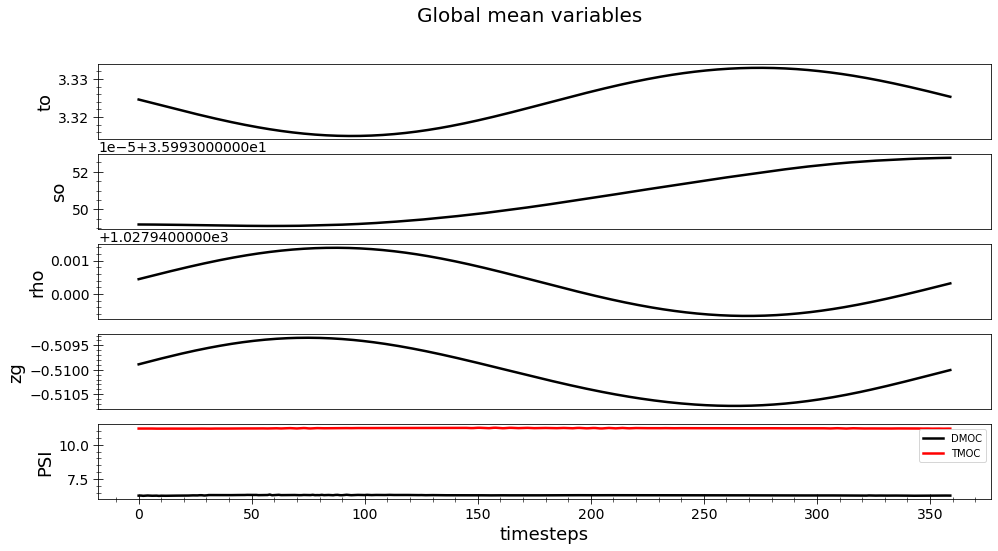

In [7]:
# Create graphs the global mean variables from Analysis 1

fig, axes = plt.subplots(5, figsize=(16,8))
fig.suptitle('Global mean variables',fontsize=20)

t_steps = np.arange(ds.t.shape[0])
# Plot data save in the var_gm dict
for i, var in enumerate(var_gm):
    axes[i].plot(t_steps, var_gm[var], label=var, c='k')
    axes[i].set_ylabel(var)
# Plot single variables
axes[3].plot(t_steps,ds.zgDE, label='zg', c='k')
axes[3].set_ylabel('zg')

axes[4].plot(t_steps,ds.psi_dmoc, label='DMOC', c='k')
axes[4].plot(t_steps,ds.psi_tmoc, label='TMOC', c='r')
axes[4].set_ylabel('PSI')
axes[4].legend()
# Remove ticks on x axis for plots 1-4
for i in range(4):
    axes[i].set_xticks([])
axes[4].set_xlabel('timesteps')

[Text(0.5, 0, 'Latitude'),
 Text(0, 0.5, 'Depth'),
 (0.0, 59.0),
 (-3000.0, 0.0),
 Text(0.5, 1.0, 'Zonal mean density and overturning rate')]

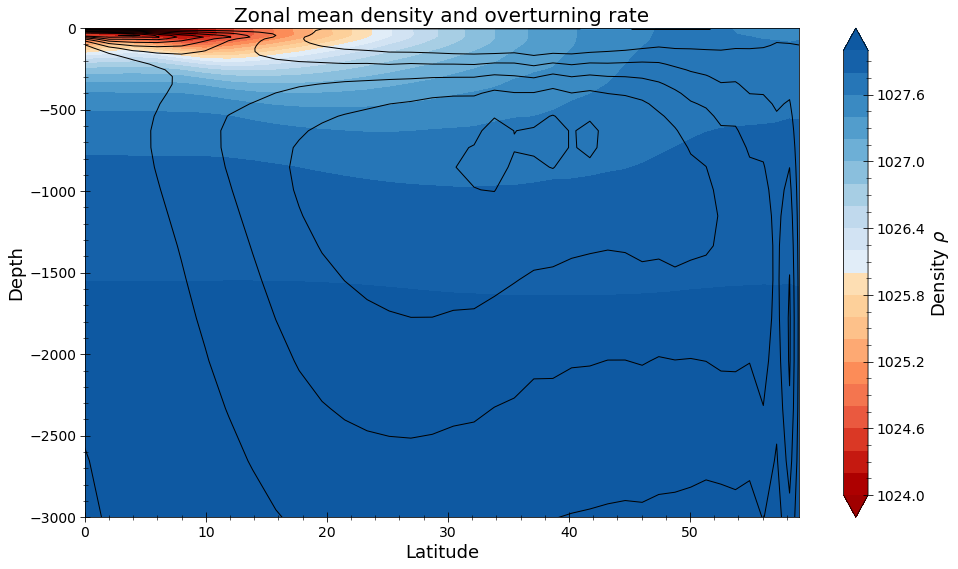

In [11]:
# Create graph for Analysis 2, Zonal mean contours of rho and psi

fig, ax = plt.subplots(1)

phi_1d=properties.coords['Y'][:,0]
X,Y = np.meshgrid(phi_1d,properties.coords['Z'][:-1]) # Cut bottom because it is masked and causes an error in contourf


c1=plt.contourf(X,Y, rho_zm.mean('t')[:-1], cmap = cmap_OB, levels=np.linspace(1024,1028,21),extend='both')
plt.contour(X,Y, ds.psi.mean('t')[:-1], colors='k', linewidths=1,levels=np.linspace(0,12,9))
cb = plt.colorbar(c1)
cb.set_label(r'Density $\rho$')
ax.set(xlabel='Latitude', ylabel='Depth', xlim=[0,59], ylim=[-3000,0], title = r'Zonal mean density and overturning rate')

[Text(0.5, 0, '$d_t$zg [10$^{-6}$ ms$^{-1}$]'),
 [],
 (-0.1, 0.1),
 (-500.0, 0.0),
 Text(0.5, 1.0, 'zg-tendency from Salinity')]

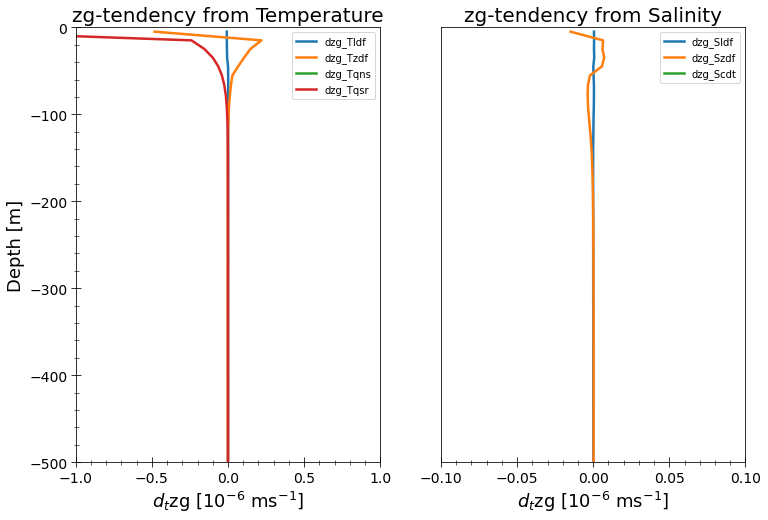

In [17]:
# Create graph for analysis 3: depth profiles of zg-tendencies in temperature and salinity

fig, ax = plt.subplots(1,2,figsize=(12,8))

magn=1e6
for var in zg_trends_T:
    ax[0].plot(zg_trends_T[var].mean('t')*magn, ds.depth_1d, label=var)
ax[0].legend()
for var in zg_trends_S:
    ax[1].plot(zg_trends_S[var].mean('t')*magn, ds.depth_1d, label=var)
ax[1].legend()

ax[0].set(xlabel=r'$d_t$zg [10$^{-6}$ ms$^{-1}$]', ylabel='Depth [m]', xlim=[-1,1], ylim=[-500,0], title='zg-tendency from Temperature')
ax[1].set(xlabel=r'$d_t$zg [10$^{-6}$ ms$^{-1}$]', yticks=[], xlim=[-.1,.1], ylim=[-500,0], title='zg-tendency from Salinity')